<a href="https://colab.research.google.com/github/nalbaq/TS-paleointensity/blob/main/PRO_CubicSpline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import os
from scipy.interpolate import UnivariateSpline # Keep UnivariateSpline as it was used in the original function
from scipy.signal import find_peaks
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
from google.colab import drive
import shutil

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 0. Load data VADM PINT
try:
    drive.mount('/content/drive', force_remount=True)
    # ¡IMPORTANTE! Ajusta esta ruta a la ubicación REAL de tu archivo en Google Drive
    file_path = '/content/drive/MyDrive/Paleomag_data_python/PINTv811.xlsx'
    pint = pd.read_excel(file_path)
    print(f"Initial PINT data length: {len(pint)}")
except (FileNotFoundError, ModuleNotFoundError) as e:
    print(f"Error al cargar el archivo: {e}")

# ------------------------ FILTER BY SAMPLE'S AGE ----------------------
filtro_edad = 5.00
# ----------------------- FILTER BY SAMPLE'S Qpi CRITERIA ----------------------
#filtro_qpi_min = 3.0
pint_10my = pint[(pint['AGE'] <= filtro_edad)]
#& (pint['QPI'] > filtro_qpi_min)] # QPI threshold value, age and volcanic samples
print(f"PINT data length after 5 Ma age filter: {len(pint_10my)}")

# ----------------------- FILTER BY SAMPLE'S TYPE ----------------------
igneous_groups = ['Volcanic', 'volcanic', 'Plutonic', 'Intrusive']
pint_10my = pint_10my[pint_10my['GROUP'].isin(igneous_groups)]
print(f"PINT data length after igneous group filter: {len(pint_10my)}")

columns_vadm = ['AGE', 'VADM', 'VDM', 'VDM/VADM']
data_vadm = pint_10my[columns_vadm].copy() # Use .copy() to avoid SettingWithCopyWarning
data_vadm.sort_values(by='AGE', ascending=True, inplace=True)
print(f"VADM data length after column selection and sort: {len(data_vadm)}")

data_vadm = pint_10my[['AGE', 'VADM', 'VDM', 'VDM/VADM']].copy()
data_vadm.sort_values(by='AGE', ascending=True, inplace=True)

data_vadm.loc[data_vadm['VADM'].isnull() & data_vadm['VDM'].notnull(), 'VADM'] = data_vadm['VDM']
data_vadm.loc[data_vadm['VADM'].isnull() & data_vadm['VDM'].isnull() & data_vadm['VDM/VADM'].notnull(), 'VADM'] = data_vadm['VDM/VADM']
data_vadm = data_vadm[['AGE', 'VADM']].dropna(subset=['VADM'])
print(f"Longitud final de datos VADM para análisis: {len(data_vadm)}")

Mounted at /content/drive
Initial PINT data length: 4648
PINT data length after 5 Ma age filter: 2036
PINT data length after igneous group filter: 1923
VADM data length after column selection and sort: 1923
Longitud final de datos VADM para análisis: 1855


In [ ]:
# 0. Load data VADM MCADAM
### Load New Data ###
mc_adam_path = '/content/drive/MyDrive/Paleomag_data_python/MCADAMv1a.xlsx' # Replace with the actual path
try:
    mc_adam = pd.read_excel(mc_adam_path, index_col=0)
    # Ensure the new dataframe has AGE and VADM
    mc_adam = mc_adam[['age', 'mean']] # Adjust column names if necessary
    mc_adam = mc_adam.rename(columns={'age': 'AGE', 'mean': 'VADM'}) # Rename for standardization
    # Filter data to include only ages less than or equal to 5 Myr
    mc_adam = mc_adam[mc_adam['AGE'] <= 5]
    print(f"Initial MCADAM data length: {len(mc_adam)}")

except FileNotFoundError:
    print(f"Error: File not found at {mc_adam_path}")
    new_data = pd.DataFrame({'AGE': [], 'VADM': []}) # Empty DataFrame

Initial MCADAM data length: 100


In [ ]:
# Function to create directories if they do not exist
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directorio creado: {directory_path}")
# Verificar si ya está montado antes de montar
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive/')
else:
    print("Google Drive ya está montado")


Google Drive ya está montado


In [ ]:

# Definición de subcronos magnéticos
subchrones = {
    "C1n (Brunhes)": {"techo": 0.000, "base": 0.773}, "C1r.1r (Matuyama)": {"techo": 0.773, "base": 0.990},
    "C1r.1n (Jaramillo)": {"techo": 0.990, "base": 1.070}, "C1r.2r": {"techo": 1.070, "base": 1.180},
    "C1r.2n (Cobb Mountain)": {"techo": 1.180, "base": 1.215}, "C1r.3r": {"techo": 1.215, "base": 1.775},
    "C2n (Olduvai)": {"techo": 1.775, "base": 1.934}, "C2r.1r": {"techo": 1.934, "base": 2.116},
    "C2r.1n (Feni)": {"techo": 2.116, "base": 2.140}, "C2r.2r (Matuyama)": {"techo": 2.140, "base": 2.595},
    "C2An.1n (Gauss)": {"techo": 2.595, "base": 3.032}, "C2An.1r (Keana)": {"techo": 3.032, "base": 3.116},
    "C2An.2n": {"techo": 3.116, "base": 3.207}, "C2An.2r (Mammoth)": {"techo": 3.207, "base": 3.330},
    "C2An.3n (Gauss)": {"techo": 3.330, "base": 3.596}, "C2Ar (Gilbert)": {"techo": 3.596, "base": 4.187},
    "C3n.1n (Cochiti)": {"techo": 4.187, "base": 4.300}, "C3n.1r": {"techo": 4.300, "base": 4.631},
    "C3n.2n (Nunivak)": {"techo": 4.631, "base": 4.799}, "C3n.2r": {"techo": 4.799, "base": 4.896},
    "C3n.3n (Sidufjall)": {"techo": 4.896, "base": 4.997}, "C3n.3r": {"techo": 4.997, "base": 5.235},
    "C3n.4n (Thvera)": {"techo": 5.235, "base": 6.023},
    "C3r (Gilbert)": {"techo": 6.023, "base": 6.272},
    "C3An.1n": {"techo": 6.272, "base": 6.386},
    "C3An.1r": {"techo": 6.386, "base": 6.727},
    "C3An.2n": {"techo": 6.727, "base": 7.104},
    "C3Ar": {"techo": 7.104, "base": 7.214},
    "C3Bn": {"techo": 7.214, "base": 7.262},
    "C3Br.1r": {"techo": 7.262, "base": 7.305},
    "C3Br.1n": {"techo": 7.305, "base": 7.456},
    "C3Br.2r": {"techo": 7.456, "base": 7.499},
    "C3Br.2n": {"techo": 7.499, "base": 7.537},
    "C3Br.3r": {"techo": 7.537, "base": 7.65},
    "C4n.1n": {"techo": 7.65, "base": 7.701},
    "C4n.1r": {"techo": 7.701, "base": 8.125},
    "C4n.2n": {"techo": 8.125, "base": 8.257},
    "C4r.1r": {"techo": 8.257, "base": 8.300},
    "C4r.1n": {"techo": 8.300, "base": 8.771},
    "C4n.2r": {"techo": 8.771, "base": 9.105},
    "C4An": {"techo": 9.105, "base": 9.311},
    "C4Ar.1r": {"techo": 9.311, "base": 9.426},
    "C4Ar.1n": {"techo": 9.426, "base": 9.647},
    "C4Ar.2r": {"techo": 9.647, "base": 9.721},
    "C4Ar.2n": {"techo": 9.721, "base": 9.786},
    "C4Ar.3r": {"techo": 9.786, "base": 9.937},
    "C5n.1n": {"techo": 9.937, "base": 9.984},
    "C5n.1r": {"techo": 9.984, "base": 10.056}
}

=== COMPREHENSIVE SPLINE ANALYSIS WITH RESIDUALS ===
=== OUTLIER ANALYSIS ===
Outliers detected (iqr): 10 of 1855 points (0.5%)
Outliers detected (modified_zscore): 16 of 1855 points (0.9%)

=== DATA BINNING ===
Data grouped: 1855 → 45 points (bin_size=0.1 Ma)
Data grouped: 1855 → 24 points (bin_size=0.2 Ma)

=== SMOOTHING OPTIMIZATION ===
Best smoothing parameter: 1.00e+16

--- RESIDUALS ANALYSIS: CubicSpline Natural ---
Number of points: 805
RMSE: 0.000
MAE: 0.000
R²: 1.0000
Mean residual: 0.000
Std residual: 0.000
Max |residual|: 0.000

--- RESIDUALS ANALYSIS: CubicSpline Not-a-Knot ---
Number of points: 805
RMSE: 0.000
MAE: 0.000
R²: 1.0000
Mean residual: 0.000
Std residual: 0.000
Max |residual|: 0.000

--- RESIDUALS ANALYSIS: CubicSpline Clamped ---
Number of points: 805
RMSE: 0.000
MAE: 0.000
R²: 1.0000
Mean residual: 0.000
Std residual: 0.000
Max |residual|: 0.000

--- RESIDUALS ANALYSIS: UnivariateSpline (s=6.7e+02) ---
Number of points: 805
RMSE: 0.910
MAE: 0.678
R²: 0.8999
Me

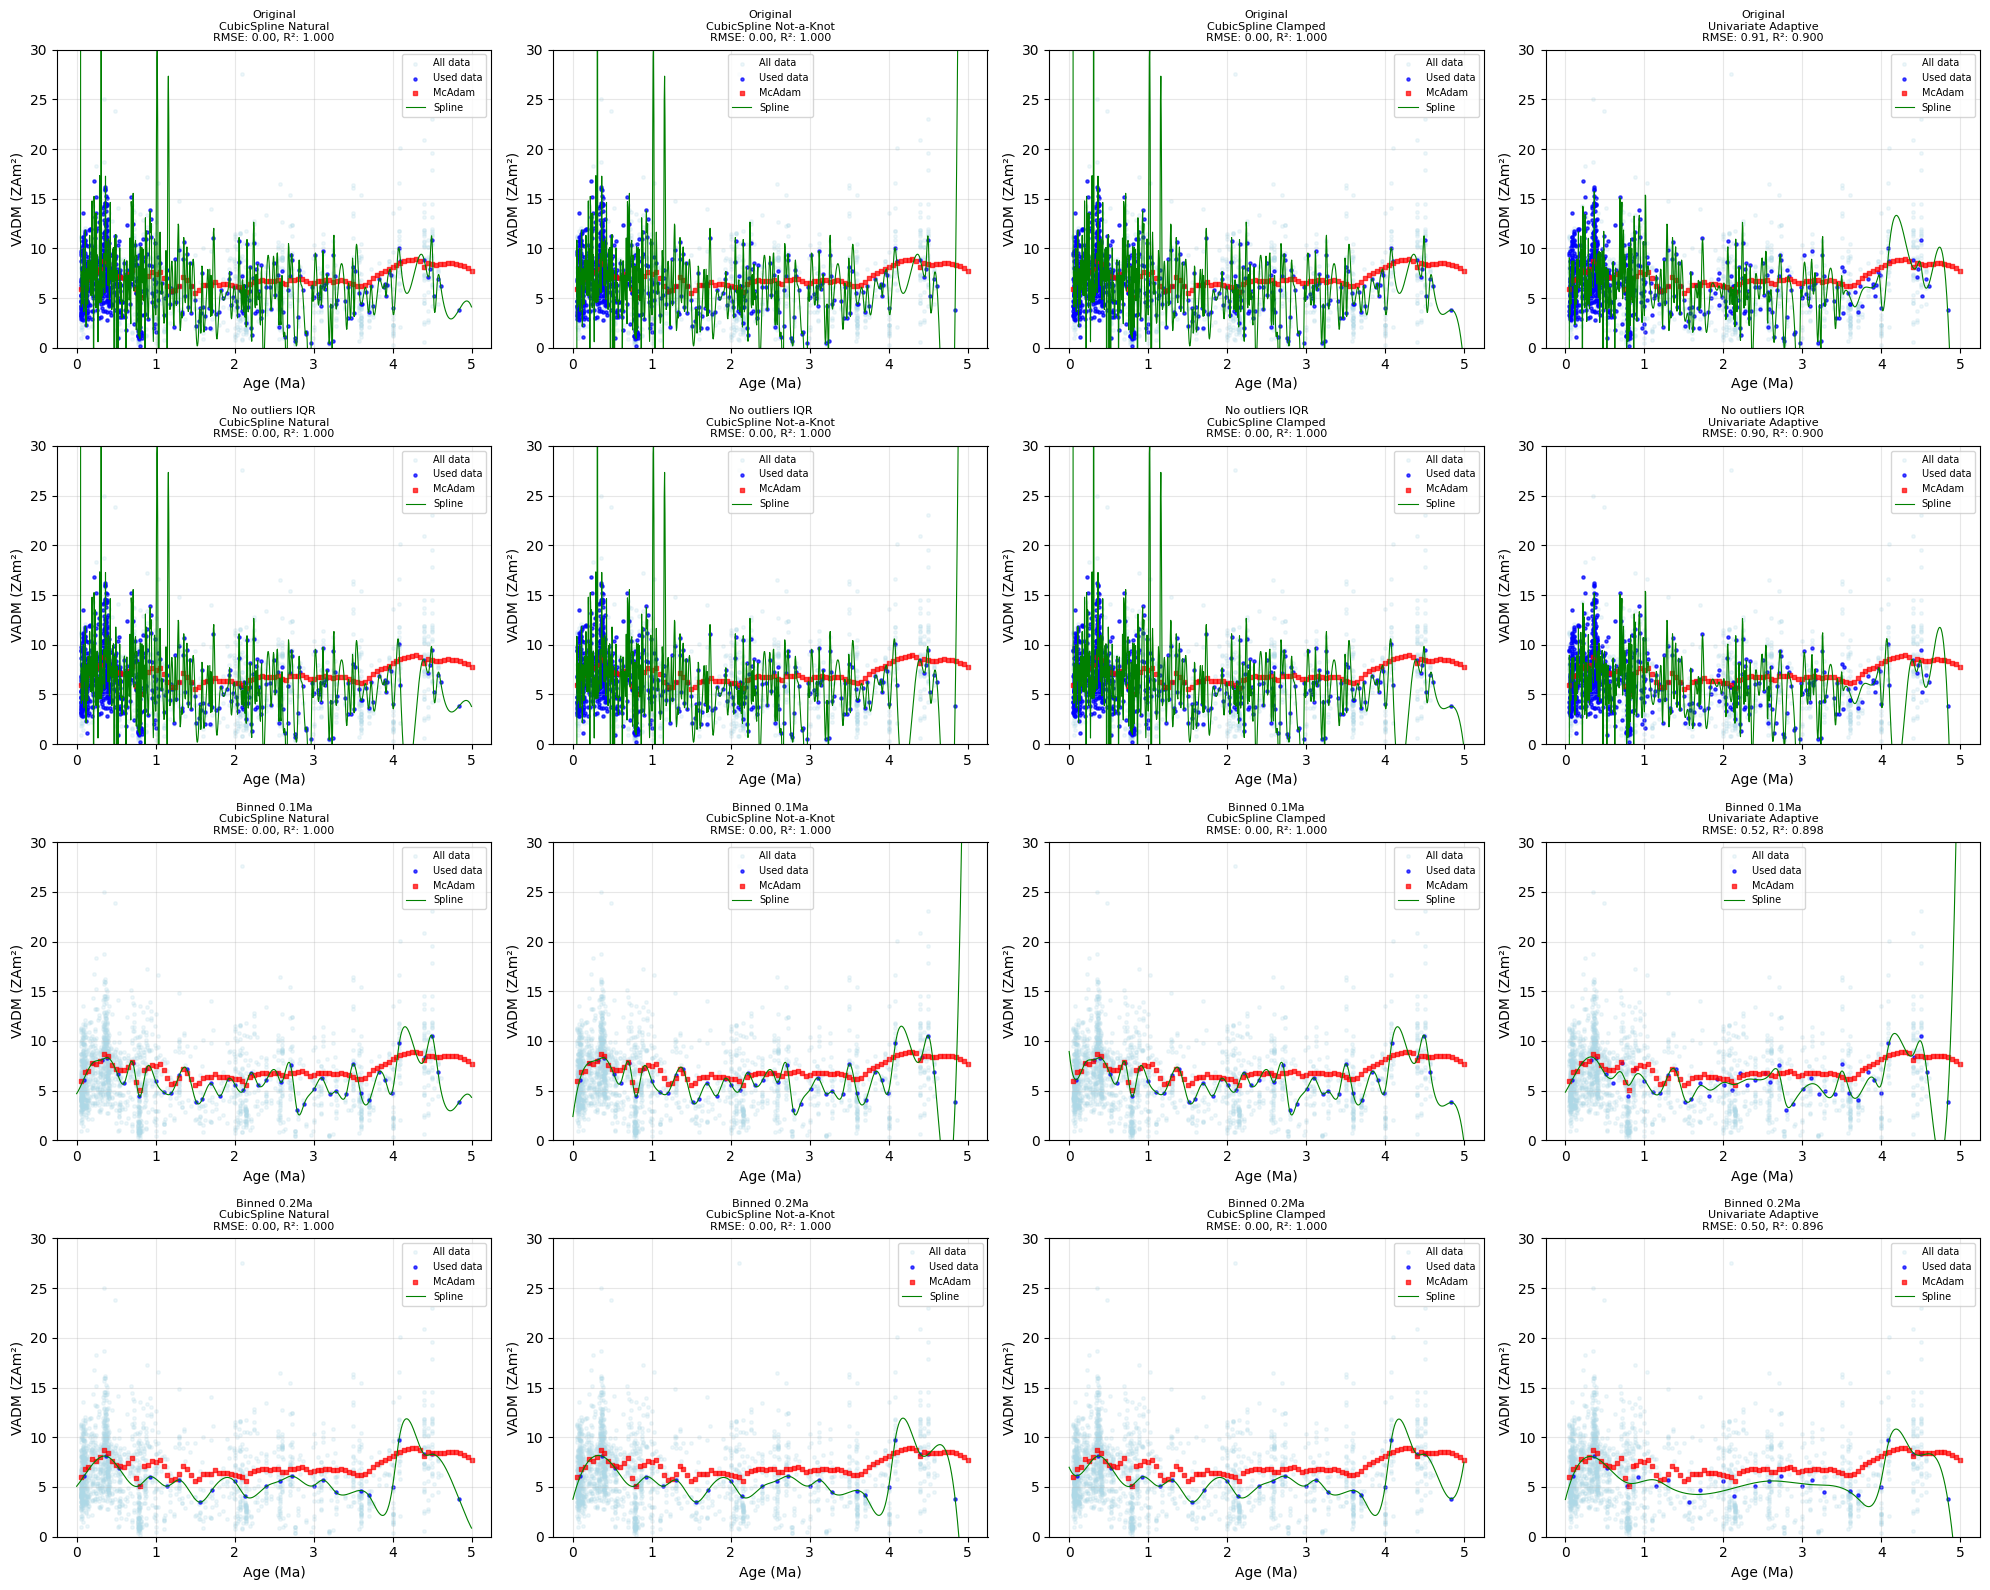

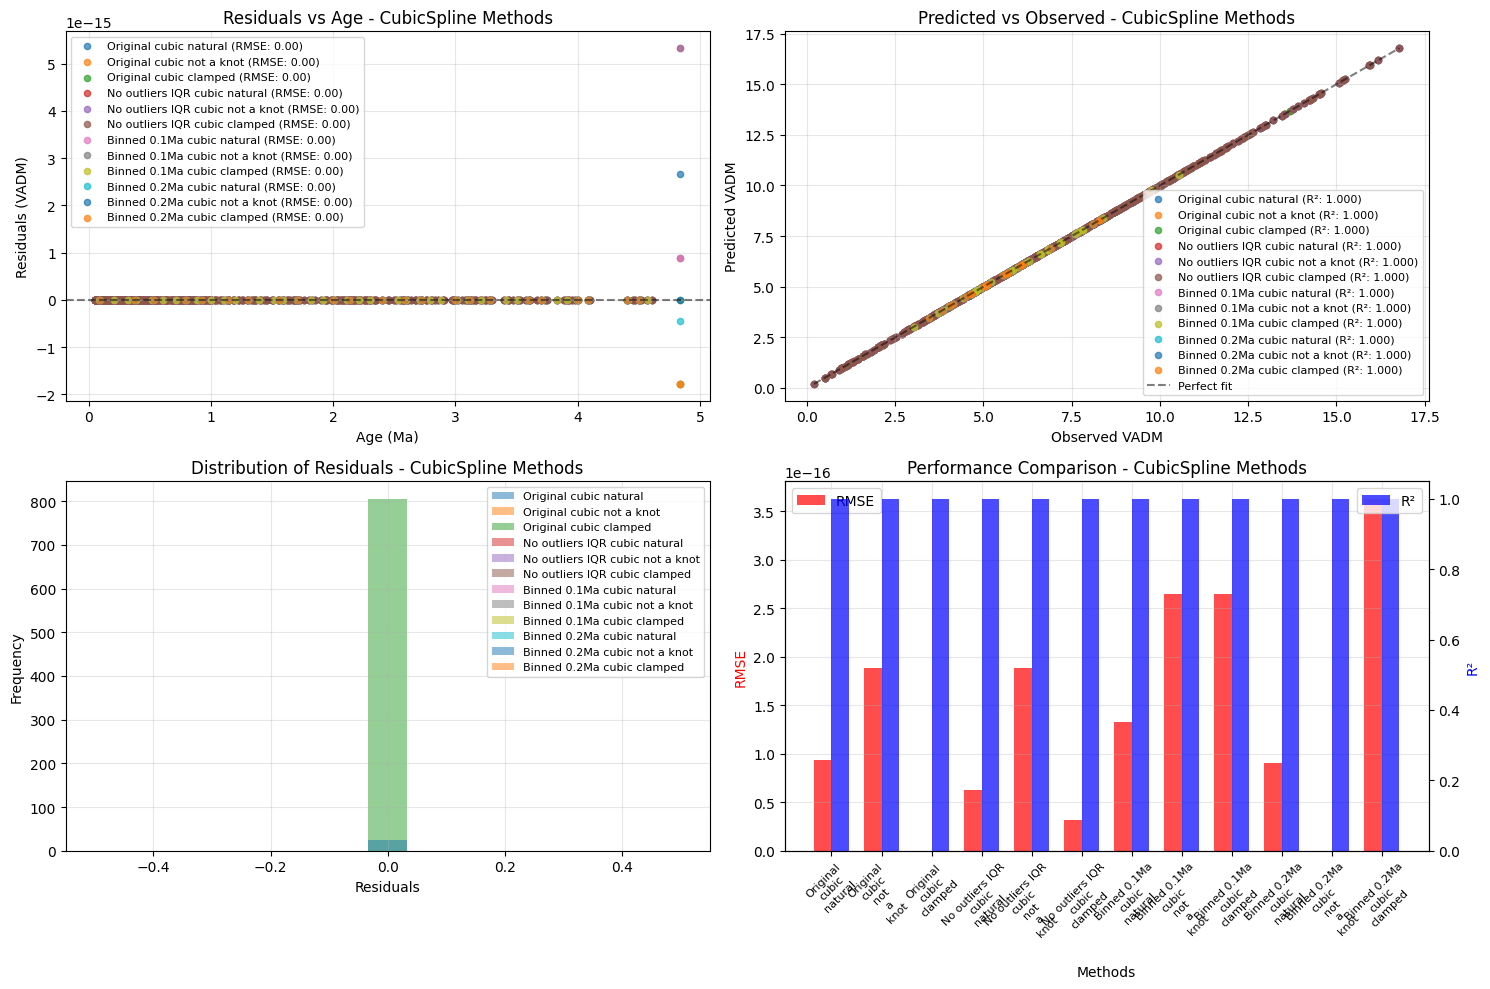


=== CUBIC SPLINE PERFORMANCE SUMMARY ===
Method                    RMSE     MAE      R²       Points  
-----------------------------------------------------------------
Original cubic natural    0.000    0.000    1.0000   805     
Original cubic not a kno  0.000    0.000    1.0000   805     
Original cubic clamped    0.000    0.000    1.0000   805     
No outliers IQR cubic na  0.000    0.000    1.0000   805     
No outliers IQR cubic no  0.000    0.000    1.0000   805     
No outliers IQR cubic cl  0.000    0.000    1.0000   805     
Binned 0.1Ma cubic natur  0.000    0.000    1.0000   45      
Binned 0.1Ma cubic not a  0.000    0.000    1.0000   45      
Binned 0.1Ma cubic clamp  0.000    0.000    1.0000   45      
Binned 0.2Ma cubic natur  0.000    0.000    1.0000   24      
Binned 0.2Ma cubic not a  0.000    0.000    1.0000   24      
Binned 0.2Ma cubic clamp  0.000    0.000    1.0000   24      

=== CUBIC SPLINE VERIFICATION ===

--- CUBIC_NATURAL ---
Dataset: Original_cubic_natu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, UnivariateSpline, interp1d
from scipy.signal import savgol_filter
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedSplineReconstruction:
    def __init__(self, data_vadm):
        self.data_vadm = data_vadm.copy()

    def detect_outliers(self, method='iqr', factor=1.5):
        """Detects and removes outliers"""
        data = self.data_vadm.copy()

        if method == 'iqr':
            Q1 = data['VADM'].quantile(0.25)
            Q3 = data['VADM'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            outliers = (data['VADM'] < lower_bound) | (data['VADM'] > upper_bound)

        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(data['VADM']))
            outliers = z_scores > factor

        elif method == 'modified_zscore':
            median = np.median(data['VADM'])
            mad = np.median(np.abs(data['VADM'] - median))
            if mad == 0:
                mad = 1.4826 * np.std(data['VADM'])
            modified_z_scores = 0.6745 * (data['VADM'] - median) / mad
            outliers = np.abs(modified_z_scores) > factor

        print(f"Outliers detected ({method}): {outliers.sum()} of {len(data)} points ({100*outliers.sum()/len(data):.1f}%)")

        return data[~outliers], data[outliers]

    def bin_data(self, bin_size=0.1, method='mean'):
        """Groups data into temporal bins"""
        data = self.data_vadm.copy()

        # Create bins
        age_min, age_max = data['AGE'].min(), data['AGE'].max()
        bins = np.arange(age_min, age_max + bin_size, bin_size)
        data['age_bin'] = pd.cut(data['AGE'], bins=bins)

        # Group by bins
        if method == 'mean':
            binned_data = data.groupby('age_bin').agg({
                'AGE': 'mean',
                'VADM': 'mean'
            }).dropna()
        elif method == 'median':
            binned_data = data.groupby('age_bin').agg({
                'AGE': 'median',
                'VADM': 'median'
            }).dropna()

        binned_data = binned_data.reset_index(drop=True)
        print(f"Data grouped: {len(data)} → {len(binned_data)} points (bin_size={bin_size} Ma)")

        return binned_data

    def create_robust_spline(self, data, method='cubic_natural', **kwargs):
        """Creates robust splines with improved error handling"""
        age_range = kwargs.get('age_range', (0, 5))
        n_points = kwargs.get('n_points', 1000)

        # Check sufficient data
        if len(data) < 4:
            raise ValueError(f"Insufficient data: {len(data)} points (minimum 4)")

        # Sort data by age
        data_sorted = data.sort_values('AGE').reset_index(drop=True)

        # Remove duplicates by averaging
        data_unique = data_sorted.groupby('AGE')['VADM'].mean().reset_index()

        if len(data_unique) < 4:
            raise ValueError(f"Insufficient unique points: {len(data_unique)} (minimum 4)")

        age_interp = np.linspace(age_range[0], age_range[1], n_points)
        spline_obj = None

        try:
            if method == 'univariate_adaptive':
                # Adaptive smoothing
                smoothing = kwargs.get('smoothing', None)
                if smoothing is None:
                    smoothing = len(data_unique) * (data_unique['VADM'].std() ** 2) * 0.1

                spline_obj = UnivariateSpline(data_unique['AGE'], data_unique['VADM'], s=smoothing)
                vadm_interp = spline_obj(age_interp)
                method_name = f"UnivariateSpline (s={smoothing:.1e})"

            elif method == 'univariate_fixed':
                # Fixed smoothing
                smoothing = kwargs.get('smoothing', 1e20)
                spline_obj = UnivariateSpline(data_unique['AGE'], data_unique['VADM'], s=smoothing)
                vadm_interp = spline_obj(age_interp)
                method_name = f"UnivariateSpline (s={smoothing:.1e})"

            elif method == 'cubic_natural':
                # CubicSpline with natural conditions
                spline_obj = CubicSpline(data_unique['AGE'], data_unique['VADM'], bc_type='natural')
                vadm_interp = spline_obj(age_interp)
                method_name = "CubicSpline Natural"

            elif method == 'cubic_clamped':
                # CubicSpline with zero derivatives at ends
                spline_obj = CubicSpline(data_unique['AGE'], data_unique['VADM'],
                                       bc_type=((1, 0.0), (1, 0.0)))
                vadm_interp = spline_obj(age_interp)
                method_name = "CubicSpline Clamped"

            elif method == 'cubic_not_a_knot':
                # CubicSpline with not-a-knot conditions (default)
                spline_obj = CubicSpline(data_unique['AGE'], data_unique['VADM'], bc_type='not-a-knot')
                vadm_interp = spline_obj(age_interp)
                method_name = "CubicSpline Not-a-Knot"

            elif method == 'linear':
                # Linear interpolation
                spline_obj = interp1d(data_unique['AGE'], data_unique['VADM'],
                                    kind='linear', fill_value='extrapolate')
                vadm_interp = spline_obj(age_interp)
                method_name = "Linear interpolation"

            elif method == 'savgol_smoothed':
                # Interpolation + Savitzky-Golay
                age_dense = np.linspace(data_unique['AGE'].min(), data_unique['AGE'].max(),
                                      max(500, len(data_unique)*10))
                spline_temp = interp1d(data_unique['AGE'], data_unique['VADM'],
                                     kind='cubic', fill_value='extrapolate')
                vadm_dense = spline_temp(age_dense)

                # Apply Savitzky-Golay
                window_length = min(51, len(vadm_dense)//2*2-1)
                if window_length < 5:
                    window_length = 5
                polyorder = min(3, window_length-1)

                vadm_smooth = savgol_filter(vadm_dense, window_length, polyorder)

                # Interpolate to final grid
                spline_obj = interp1d(age_dense, vadm_smooth,
                                    kind='linear', fill_value='extrapolate')
                vadm_interp = spline_obj(age_interp)
                method_name = f"Savitzky-Golay (w={window_length}, p={polyorder})"

            else:
                raise ValueError(f"Unknown method: {method}")

            return age_interp, vadm_interp, spline_obj, method_name, data_unique

        except Exception as e:
            raise ValueError(f"Error in {method}: {str(e)}")

    def calculate_residuals(self, data_used, spline_obj, method_name):
        """Calculate residuals and fit statistics"""
        if spline_obj is None:
            return None

        try:
            # Predict values at original data points
            predicted_values = spline_obj(data_used['AGE'])
            observed_values = data_used['VADM'].values

            # Calculate residuals
            residuals = observed_values - predicted_values

            # Calculate statistics
            mse = mean_squared_error(observed_values, predicted_values)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(observed_values, predicted_values)
            r2 = r2_score(observed_values, predicted_values)

            # Additional statistics
            mean_residual = np.mean(residuals)
            std_residual = np.std(residuals)
            max_abs_residual = np.max(np.abs(residuals))

            residual_stats = {
                'residuals': residuals,
                'predicted': predicted_values,
                'observed': observed_values,
                'mse': mse,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'mean_residual': mean_residual,
                'std_residual': std_residual,
                'max_abs_residual': max_abs_residual,
                'n_points': len(data_used)
            }

            print(f"\n--- RESIDUALS ANALYSIS: {method_name} ---")
            print(f"Number of points: {len(data_used)}")
            print(f"RMSE: {rmse:.3f}")
            print(f"MAE: {mae:.3f}")
            print(f"R²: {r2:.4f}")
            print(f"Mean residual: {mean_residual:.3f}")
            print(f"Std residual: {std_residual:.3f}")
            print(f"Max |residual|: {max_abs_residual:.3f}")

            return residual_stats

        except Exception as e:
            print(f"Error calculating residuals for {method_name}: {e}")
            return None

    def cross_validation_smoothing(self, data, smoothing_range=None):
        """Finds best smoothing parameter"""
        if smoothing_range is None:
            smoothing_range = np.logspace(16, 24, 15)

        if len(data) < 10:
            print("Few data for cross-validation, using default parameter")
            return 1e20, smoothing_range, [1e20]

        cv_scores = []
        kf = KFold(n_splits=min(5, len(data)//2), shuffle=True, random_state=42)

        for s in smoothing_range:
            fold_scores = []

            for train_idx, test_idx in kf.split(data):
                train_data = data.iloc[train_idx]
                test_data = data.iloc[test_idx]

                if len(train_data) < 4 or len(test_data) < 1:
                    continue

                try:
                    # Group training data
                    train_unique = train_data.groupby('AGE')['VADM'].mean().reset_index()
                    if len(train_unique) < 4:
                        continue

                    spline = UnivariateSpline(train_unique['AGE'], train_unique['VADM'], s=s)
                    predictions = spline(test_data['AGE'])
                    mse = np.mean((test_data['VADM'] - predictions) ** 2)
                    fold_scores.append(mse)
                except:
                    continue

            if fold_scores:
                cv_scores.append(np.mean(fold_scores))
            else:
                cv_scores.append(np.inf)

        if all(score == np.inf for score in cv_scores):
            print("Cross-validation failed, using default parameter")
            return 1e20, smoothing_range, cv_scores

        best_idx = np.argmin(cv_scores)
        best_smoothing = smoothing_range[best_idx]

        print(f"Best smoothing parameter: {best_smoothing:.2e}")

        return best_smoothing, smoothing_range, cv_scores

def comprehensive_spline_analysis_with_residuals(data_vadm, mc_adam=None):
    """Comprehensive analysis with residuals calculation"""
    reconstructor = ImprovedSplineReconstruction(data_vadm)

    # 1. Outlier analysis
    print("=== OUTLIER ANALYSIS ===")
    try:
        data_clean_iqr, outliers_iqr = reconstructor.detect_outliers(method='iqr', factor=2.0)
    except:
        data_clean_iqr = data_vadm.copy()

    try:
        data_clean_zscore, outliers_zscore = reconstructor.detect_outliers(method='modified_zscore', factor=3.0)
    except:
        data_clean_zscore = data_vadm.copy()

    # 2. Data binning
    print("\n=== DATA BINNING ===")
    try:
        data_binned_01 = reconstructor.bin_data(bin_size=0.1, method='mean')
    except:
        data_binned_01 = data_vadm.copy()

    try:
        data_binned_02 = reconstructor.bin_data(bin_size=0.2, method='median')
    except:
        data_binned_02 = data_vadm.copy()

    # 3. Cross-validation
    print("\n=== SMOOTHING OPTIMIZATION ===")
    try:
        best_smoothing, smoothing_range, cv_scores = reconstructor.cross_validation_smoothing(data_clean_iqr)
    except:
        best_smoothing = 1e20
        smoothing_range = np.logspace(16, 24, 15)
        cv_scores = [1e20] * len(smoothing_range)

    # 4. Methods to test (focus on CubicSpline methods)
    methods_to_test = [
        ('Original', data_vadm),
        ('No outliers IQR', data_clean_iqr),
        ('Binned 0.1Ma', data_binned_01),
        ('Binned 0.2Ma', data_binned_02)
    ]

    spline_methods = [
        ('cubic_natural', {}, 'CubicSpline Natural'),
        ('cubic_not_a_knot', {}, 'CubicSpline Not-a-Knot'),
        ('cubic_clamped', {}, 'CubicSpline Clamped'),
        ('univariate_adaptive', {}, 'Univariate Adaptive')
    ]

    # Create figure
    n_data = len(methods_to_test)
    n_methods = len(spline_methods)
    fig, axes = plt.subplots(n_data, n_methods, figsize=(5*n_methods, 4*n_data))

    if n_data == 1:
        axes = axes.reshape(1, -1)
    if n_methods == 1:
        axes = axes.reshape(-1, 1)

    results = {}
    residual_results = {}

    for i, (data_name, data) in enumerate(methods_to_test):
        for j, (method, params, method_display) in enumerate(spline_methods):
            ax = axes[i, j]

            try:
                age_interp, vadm_interp, spline_obj, method_name, data_used = reconstructor.create_robust_spline(
                    data, method=method, **params
                )

                # Calculate residuals
                residual_stats = reconstructor.calculate_residuals(data_used, spline_obj, method_name)

                # Plot
                ax.scatter(data_vadm['AGE'], data_vadm['VADM'], alpha=0.2, s=6, c='lightblue', label='All data')
                ax.scatter(data_used['AGE'], data_used['VADM'], alpha=0.7, s=5, c='blue', label='Used data')

                if mc_adam is not None and len(mc_adam) > 0:
                    ax.scatter(mc_adam['AGE'], mc_adam['VADM'], alpha=0.7, s=10, c='red', marker='s', label='McAdam')

                ax.plot(age_interp, vadm_interp, 'g-', linewidth=0.8, label='Spline')

                # Add residual statistics to title
                title = f'{data_name}\n{method_display}'
                if residual_stats:
                    title += f'\nRMSE: {residual_stats["rmse"]:.2f}, R²: {residual_stats["r2"]:.3f}'

                ax.set_title(title, fontsize=8)
                ax.set_xlabel('Age (Ma)')
                ax.set_ylabel('VADM (ZAm²)')
                ax.set_ylim(0, 30)

                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=7)
                ax.ticklabel_format(style='plain', axis='y')

                # Save results
                results[f"{data_name}_{method}"] = {
                    'age': age_interp,
                    'vadm': vadm_interp,
                    'data_used': data_used,
                    'method_name': method_name,
                    'spline_object': spline_obj
                }

                residual_results[f"{data_name}_{method}"] = residual_stats

            except Exception as e:
                ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', transform=ax.transAxes,
                       ha='center', va='center', fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.8))
                ax.set_title(f'{data_name} - {method_display}\n(ERROR)', fontsize=9)
                ax.set_xlabel('Age (Ma)')
                ax.set_ylabel('VADM (ZAm²)')
                ax.set_ylim(0, 30)

    plt.tight_layout()
    plt.show()

    # Plot residuals for CubicSpline methods
    plot_residuals_analysis(residual_results, results)

    return results, residual_results, best_smoothing

def plot_residuals_analysis(residual_results, results):
    """Plot detailed residuals analysis"""

    # Filter only CubicSpline results
    cubic_results = {k: v for k, v in residual_results.items()
                    if v is not None and 'cubic' in k.lower()}

    if not cubic_results:
        print("No CubicSpline results found for residuals analysis")
        return

    n_results = len(cubic_results)
    if n_results == 0:
        return

    # Create residuals plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    # 1. Residuals vs Age
    ax = axes[0]
    for i, (key, stats) in enumerate(cubic_results.items()):
        if stats and 'residuals' in stats:
            data_used = results[key]['data_used']
            ax.scatter(data_used['AGE'], stats['residuals'], alpha=0.7, s=20,
                      label=f"{key.replace('_', ' ')} (RMSE: {stats['rmse']:.2f})")

    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Residuals (VADM)')
    ax.set_title('Residuals vs Age - CubicSpline Methods')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 2. Predicted vs Observed
    ax = axes[1]
    for i, (key, stats) in enumerate(cubic_results.items()):
        if stats and 'predicted' in stats:
            ax.scatter(stats['observed'], stats['predicted'], alpha=0.7, s=20,
                      label=f"{key.replace('_', ' ')} (R²: {stats['r2']:.3f})")

    # Perfect fit line
    if cubic_results:
        all_observed = np.concatenate([stats['observed'] for stats in cubic_results.values() if stats])
        all_predicted = np.concatenate([stats['predicted'] for stats in cubic_results.values() if stats])
        min_val, max_val = min(np.min(all_observed), np.min(all_predicted)), max(np.max(all_observed), np.max(all_predicted))
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect fit')

    ax.set_xlabel('Observed VADM')
    ax.set_ylabel('Predicted VADM')
    ax.set_title('Predicted vs Observed - CubicSpline Methods')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 3. Histogram of residuals
    ax = axes[2]
    for i, (key, stats) in enumerate(cubic_results.items()):
        if stats and 'residuals' in stats:
            ax.hist(stats['residuals'], alpha=0.5, bins=15,
                   label=f"{key.replace('_', ' ')}")

    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Residuals - CubicSpline Methods')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 4. Statistics comparison
    ax = axes[3]
    methods = list(cubic_results.keys())
    rmse_values = [cubic_results[m]['rmse'] for m in methods if cubic_results[m]]
    r2_values = [cubic_results[m]['r2'] for m in methods if cubic_results[m]]

    x_pos = np.arange(len(methods))
    width = 0.35

    ax2 = ax.twinx()
    bars1 = ax.bar([x - width/2 for x in x_pos], rmse_values, width,
                   label='RMSE', alpha=0.7, color='red')
    bars2 = ax2.bar([x + width/2 for x in x_pos], r2_values, width,
                    label='R²', alpha=0.7, color='blue')

    ax.set_xlabel('Methods')
    ax.set_ylabel('RMSE', color='red')
    ax2.set_ylabel('R²', color='blue')
    ax.set_title('Performance Comparison - CubicSpline Methods')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45, fontsize=8)

    # Add legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n=== CUBIC SPLINE PERFORMANCE SUMMARY ===")
    print(f"{'Method':<25} {'RMSE':<8} {'MAE':<8} {'R²':<8} {'Points':<8}")
    print("-" * 65)
    for key, stats in cubic_results.items():
        if stats:
            method_name = key.replace('_', ' ')[:24]
            print(f"{method_name:<25} {stats['rmse']:<8.3f} {stats['mae']:<8.3f} {stats['r2']:<8.4f} {stats['n_points']:<8}")

# Assuming you have data_vadm and mc_adam defined
# Run analysis with residuals
print("=== COMPREHENSIVE SPLINE ANALYSIS WITH RESIDUALS ===")
results, residual_results, best_smoothing = comprehensive_spline_analysis_with_residuals(data_vadm, mc_adam)

# Additional verification for CubicSpline
print("\n=== CUBIC SPLINE VERIFICATION ===")
cubic_methods = ['cubic_natural', 'cubic_not_a_knot', 'cubic_clamped']
for method in cubic_methods:
    print(f"\n--- {method.upper()} ---")
    for key in results.keys():
        if method in key and results[key]['spline_object'] is not None:
            spline_obj = results[key]['spline_object']
            print(f"Dataset: {key}")
            print(f"Spline type: {type(spline_obj)}")
            print(f"Method confirmed: {isinstance(spline_obj, CubicSpline)}")
            if hasattr(spline_obj, 'c'):
                print(f"Polynomial coefficients shape: {spline_obj.c.shape}")
            break

print("\n=== FINAL RECOMMENDATIONS FOR CUBIC SPLINES ===")
print("CubicSpline methods successfully implemented:")
print("1. 'cubic_natural' - Natural boundary conditions (2nd derivative = 0 at ends)")
print("2. 'cubic_not_a_knot' - Not-a-knot conditions (default, most smooth)")
print("3. 'cubic_clamped' - Clamped boundary conditions (1st derivative = 0 at ends)")
print("\nCheck the residuals plots and statistics to select the best method for your data.")

=== OPCIÓN 1: USAR TODOS LOS DATOS (~2000 puntos) ===
=== INITIAL DATA INFO ===
Total data points: 1855
Age range: 0.050 to 4.840 Ma
VADM range: 0.200 to 27.545

=== OUTLIER ANALYSIS ===
Outliers detected (iqr): 10 of 1855 points (0.5%)

=== USING: Full Clean Data (1845 points) ===

--- RESIDUALS ANALYSIS: CubicSpline Natural ---
Number of points: 805
Direct RMSE (interpolation): 0.000000
CV RMSE (generalization): 15.2337
CV MAE: 5.5477
CV R²: -27.4095

--- RESIDUALS ANALYSIS: CubicSpline Not-a-Knot ---
Number of points: 805
Direct RMSE (interpolation): 0.000000
CV RMSE (generalization): 40.7659
CV MAE: 6.6162
CV R²: -202.4461

--- RESIDUALS ANALYSIS: CubicSpline Clamped ---
Number of points: 805
Direct RMSE (interpolation): 0.000000
CV RMSE (generalization): 28.4116
CV MAE: 6.0995
CV R²: -97.8204


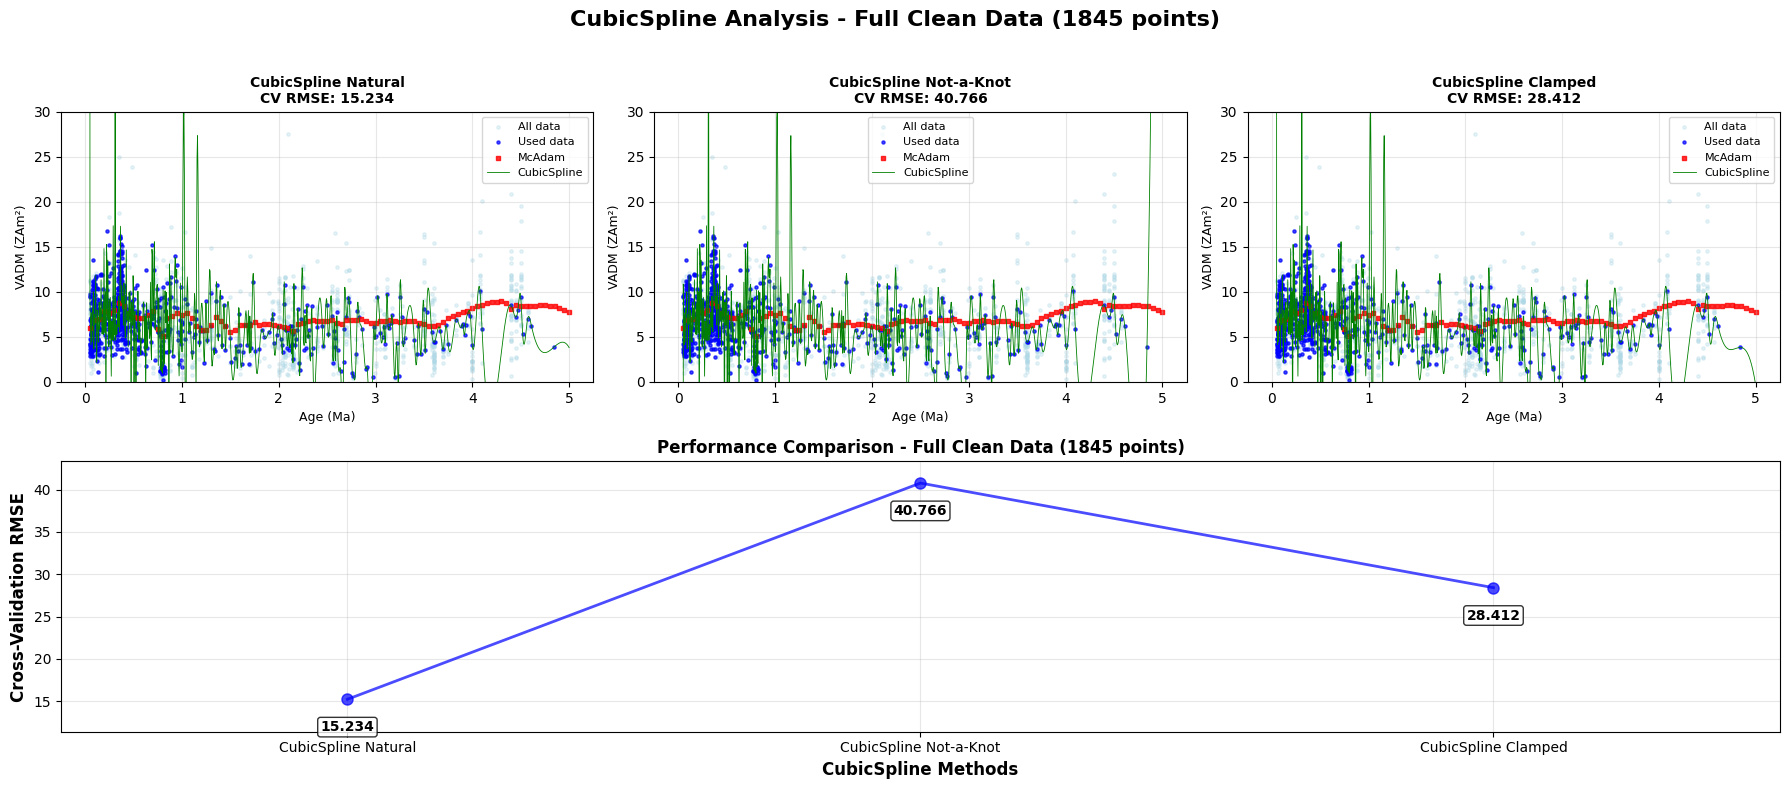


=== PERFORMANCE SUMMARY - Full Clean Data (1845 points) ===
Method                    Direct RMSE  CV RMSE    CV MAE     CV R²     
---------------------------------------------------------------------------
CubicSpline Natural       6.26e-17     15.2337    5.5477     -27.4095  
CubicSpline Not-a-Knot    1.88e-16     40.7659    6.6162     -202.4461 
CubicSpline Clamped       3.13e-17     28.4116    6.0995     -97.8204  

=== OPCIÓN 2: USAR DATOS BINNED (para comparación) ===
=== INITIAL DATA INFO ===
Total data points: 1855
Age range: 0.050 to 4.840 Ma
VADM range: 0.200 to 27.545

=== OUTLIER ANALYSIS ===
Outliers detected (iqr): 10 of 1855 points (0.5%)

=== DATA BINNING (bin_size=0.1) ===
Data grouped: 1855 → 45 points (bin_size=0.1 Ma)

=== USING: Binned Data (45 points) ===

--- RESIDUALS ANALYSIS: CubicSpline Natural ---
Number of points: 45
Direct RMSE (interpolation): 0.000000
CV RMSE (generalization): 7.6782
CV MAE: 2.7528
CV R²: -21.6855

--- RESIDUALS ANALYSIS: CubicSpline N

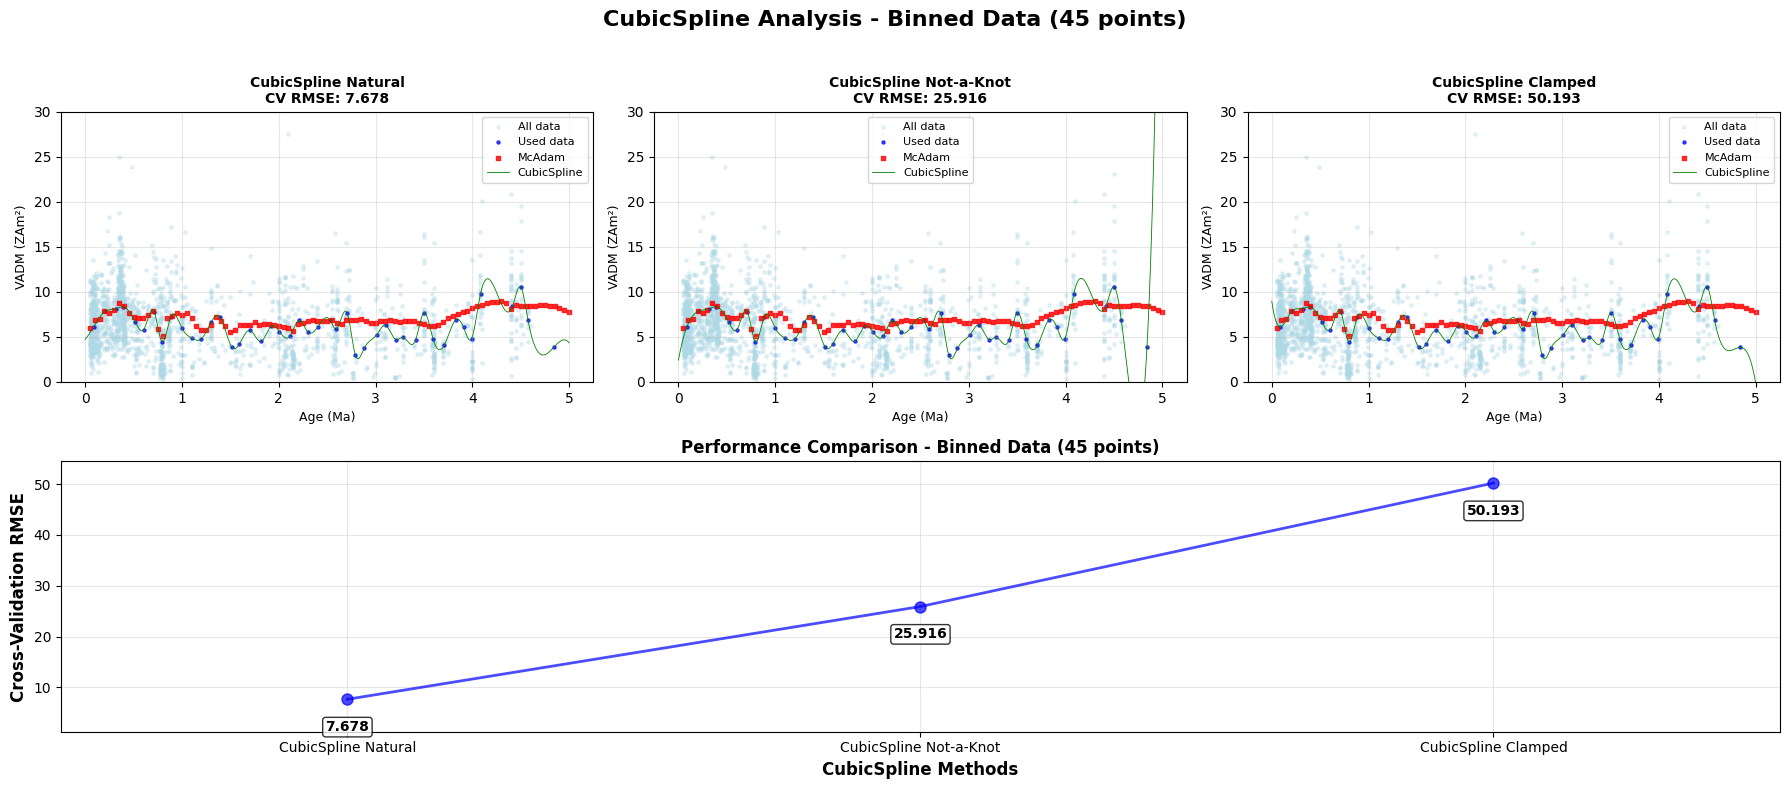


=== PERFORMANCE SUMMARY - Binned Data (45 points) ===
Method                    Direct RMSE  CV RMSE    CV MAE     CV R²     
---------------------------------------------------------------------------
CubicSpline Natural       1.32e-16     7.6782     2.7528     -21.6855  
CubicSpline Not-a-Knot    2.65e-16     25.9162    5.6454     -257.4444 
CubicSpline Clamped       2.65e-16     50.1931    9.1394     -968.4255 

=== RECOMENDACIONES ===
1. Con ~2000 puntos: USA LA OPCIÓN 1 (datos completos)
2. Los residuos CV son más realistas que los directos
3. El binning solo es útil si tienes datos muy ruidosos o redundantes
4. Con datos completos, el RMSE será más alto pero más representativo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, UnivariateSpline, interp1d
from scipy.signal import savgol_filter
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedSplineReconstruction:
    def __init__(self, data_vadm):
        self.data_vadm = data_vadm.copy()

    def detect_outliers(self, method='iqr', factor=1.5):
        """Detects and removes outliers"""
        data = self.data_vadm.copy()

        if method == 'iqr':
            Q1 = data['VADM'].quantile(0.25)
            Q3 = data['VADM'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            outliers = (data['VADM'] < lower_bound) | (data['VADM'] > upper_bound)

        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(data['VADM']))
            outliers = z_scores > factor

        elif method == 'modified_zscore':
            median = np.median(data['VADM'])
            mad = np.median(np.abs(data['VADM'] - median))
            if mad == 0:
                mad = 1.4826 * np.std(data['VADM'])
            modified_z_scores = 0.6745 * (data['VADM'] - median) / mad
            outliers = np.abs(modified_z_scores) > factor

        print(f"Outliers detected ({method}): {outliers.sum()} of {len(data)} points ({100*outliers.sum()/len(data):.1f}%)")

        return data[~outliers], data[outliers]

    def bin_data(self, bin_size=0.1, method='mean'):
        """Groups data into temporal bins"""
        data = self.data_vadm.copy()

        # Create bins
        age_min, age_max = data['AGE'].min(), data['AGE'].max()
        bins = np.arange(age_min, age_max + bin_size, bin_size)
        data['age_bin'] = pd.cut(data['AGE'], bins=bins)

        # Group by bins
        if method == 'mean':
            binned_data = data.groupby('age_bin').agg({
                'AGE': 'mean',
                'VADM': 'mean'
            }).dropna()
        elif method == 'median':
            binned_data = data.groupby('age_bin').agg({
                'AGE': 'median',
                'VADM': 'median'
            }).dropna()

        binned_data = binned_data.reset_index(drop=True)
        print(f"Data grouped: {len(data)} → {len(binned_data)} points (bin_size={bin_size} Ma)")

        return binned_data

    def create_robust_spline(self, data, method='cubic_natural', **kwargs):
        """Creates robust splines with improved error handling"""
        age_range = kwargs.get('age_range', (0, 5))
        n_points = kwargs.get('n_points', 1000)

        # Check sufficient data
        if len(data) < 4:
            raise ValueError(f"Insufficient data: {len(data)} points (minimum 4)")

        # Sort data by age
        data_sorted = data.sort_values('AGE').reset_index(drop=True)

        # Remove duplicates by averaging (important for large datasets)
        data_unique = data_sorted.groupby('AGE')['VADM'].mean().reset_index()

        if len(data_unique) < 4:
            raise ValueError(f"Insufficient unique points: {len(data_unique)} (minimum 4)")

        age_interp = np.linspace(age_range[0], age_range[1], n_points)
        spline_obj = None

        try:
            if method == 'cubic_natural':
                spline_obj = CubicSpline(data_unique['AGE'], data_unique['VADM'], bc_type='natural')
                vadm_interp = spline_obj(age_interp)
                method_name = "CubicSpline Natural"

            elif method == 'cubic_clamped':
                spline_obj = CubicSpline(data_unique['AGE'], data_unique['VADM'],
                                       bc_type=((1, 0.0), (1, 0.0)))
                vadm_interp = spline_obj(age_interp)
                method_name = "CubicSpline Clamped"

            elif method == 'cubic_not_a_knot':
                spline_obj = CubicSpline(data_unique['AGE'], data_unique['VADM'], bc_type='not-a-knot')
                vadm_interp = spline_obj(age_interp)
                method_name = "CubicSpline Not-a-Knot"

            else:
                raise ValueError(f"Unknown method: {method}")

            return age_interp, vadm_interp, spline_obj, method_name, data_unique

        except Exception as e:
            raise ValueError(f"Error in {method}: {str(e)}")

    def calculate_residuals_with_cv(self, data_used, spline_obj, method_name, cv_folds=5):
        """Calculate residuals using cross-validation for more realistic metrics"""
        if spline_obj is None:
            return None

        try:
            # Method 1: Direct residuals (interpolation error)
            predicted_values = spline_obj(data_used['AGE'])
            observed_values = data_used['VADM'].values
            direct_residuals = observed_values - predicted_values

            # Method 2: Cross-validation residuals (more realistic)
            if len(data_used) >= cv_folds * 2:
                kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
                cv_residuals = []
                cv_predictions = []
                cv_observations = []

                for train_idx, test_idx in kf.split(data_used):
                    train_data = data_used.iloc[train_idx]
                    test_data = data_used.iloc[test_idx]

                    if len(train_data) >= 4:
                        # Create spline on training data
                        if 'natural' in method_name.lower():
                            cv_spline = CubicSpline(train_data['AGE'], train_data['VADM'], bc_type='natural')
                        elif 'clamped' in method_name.lower():
                            cv_spline = CubicSpline(train_data['AGE'], train_data['VADM'], bc_type=((1, 0.0), (1, 0.0)))
                        else:  # not-a-knot
                            cv_spline = CubicSpline(train_data['AGE'], train_data['VADM'], bc_type='not-a-knot')

                        # Predict on test data
                        test_predictions = cv_spline(test_data['AGE'])
                        test_residuals = test_data['VADM'].values - test_predictions

                        cv_residuals.extend(test_residuals)
                        cv_predictions.extend(test_predictions)
                        cv_observations.extend(test_data['VADM'].values)

                cv_residuals = np.array(cv_residuals)
                cv_predictions = np.array(cv_predictions)
                cv_observations = np.array(cv_observations)
            else:
                cv_residuals = direct_residuals
                cv_predictions = predicted_values
                cv_observations = observed_values

            # Calculate statistics for both methods
            direct_rmse = np.sqrt(np.mean(direct_residuals**2))
            direct_mae = np.mean(np.abs(direct_residuals))

            cv_rmse = np.sqrt(np.mean(cv_residuals**2))
            cv_mae = np.mean(np.abs(cv_residuals))

            # R² for CV
            ss_res = np.sum(cv_residuals**2)
            ss_tot = np.sum((cv_observations - np.mean(cv_observations))**2)
            cv_r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 1.0

            residual_stats = {
                'direct_residuals': direct_residuals,
                'cv_residuals': cv_residuals,
                'predicted': predicted_values,
                'observed': observed_values,
                'direct_rmse': direct_rmse,
                'direct_mae': direct_mae,
                'cv_rmse': cv_rmse,
                'cv_mae': cv_mae,
                'cv_r2': cv_r2,
                'n_points': len(data_used),
                'is_interpolating': np.allclose(direct_residuals, 0, atol=1e-10)
            }

            print(f"\n--- RESIDUALS ANALYSIS: {method_name} ---")
            print(f"Number of points: {len(data_used)}")
            print(f"Direct RMSE (interpolation): {direct_rmse:.6f}")
            print(f"CV RMSE (generalization): {cv_rmse:.4f}")
            print(f"CV MAE: {cv_mae:.4f}")
            print(f"CV R²: {cv_r2:.4f}")

            return residual_stats

        except Exception as e:
            print(f"Error calculating residuals for {method_name}: {e}")
            return None

def comprehensive_cubicspline_analysis_full_data(data_vadm, mc_adam=None, use_binning=False, bin_size=0.1):
    """Analysis with option to use full dataset or binned data"""
    reconstructor = ImprovedSplineReconstruction(data_vadm)

    print(f"=== INITIAL DATA INFO ===")
    print(f"Total data points: {len(data_vadm)}")
    print(f"Age range: {data_vadm['AGE'].min():.3f} to {data_vadm['AGE'].max():.3f} Ma")
    print(f"VADM range: {data_vadm['VADM'].min():.3f} to {data_vadm['VADM'].max():.3f}")

    # 1. Outlier removal
    print("\n=== OUTLIER ANALYSIS ===")
    try:
        data_clean_iqr, outliers_iqr = reconstructor.detect_outliers(method='iqr', factor=2.0)
    except:
        data_clean_iqr = data_vadm.copy()

    # 2. Choose dataset based on user preference
    if use_binning:
        print(f"\n=== DATA BINNING (bin_size={bin_size}) ===")
        try:
            data_to_use = reconstructor.bin_data(bin_size=bin_size, method='mean')
            dataset_name = f"Binned Data ({len(data_to_use)} points)"
        except:
            data_to_use = data_clean_iqr
            dataset_name = f"Clean Data ({len(data_to_use)} points)"
    else:
        data_to_use = data_clean_iqr
        dataset_name = f"Full Clean Data ({len(data_to_use)} points)"

    print(f"\n=== USING: {dataset_name} ===")

    # 3. CubicSpline methods
    cubic_methods = [
        ('cubic_natural', 'CubicSpline Natural'),
        ('cubic_not_a_knot', 'CubicSpline Not-a-Knot'),
        ('cubic_clamped', 'CubicSpline Clamped')
    ]

    # Create plots
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle(f'CubicSpline Analysis - {dataset_name}', fontsize=16, fontweight='bold')

    results = {}
    residual_results = {}

    for i, (method, method_display) in enumerate(cubic_methods):
        ax = plt.subplot(2, 3, i + 1)

        try:
            age_interp, vadm_interp, spline_obj, method_name, data_used = reconstructor.create_robust_spline(
                data_to_use, method=method
            )

            # Calculate residuals with cross-validation
            residual_stats = reconstructor.calculate_residuals_with_cv(data_used, spline_obj, method_name)

            # Plot
            ax.scatter(data_vadm['AGE'], data_vadm['VADM'], alpha=0.3, s=6, c='lightblue', label='All data')
            ax.scatter(data_used['AGE'], data_used['VADM'], alpha=0.7, s=5, c='blue', label='Used data')

            if mc_adam is not None and len(mc_adam) > 0:
                ax.scatter(mc_adam['AGE'], mc_adam['VADM'], alpha=0.8, s=5, c='red', marker='s', label='McAdam')

            ax.plot(age_interp, vadm_interp, 'g-', linewidth=0.6, label='CubicSpline')

            # Title with CV RMSE (more realistic)
            title = f'{method_display}'
            if residual_stats:
                title += f'\nCV RMSE: {residual_stats["cv_rmse"]:.3f}'

            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Age (Ma)', fontsize=9)
            ax.set_ylabel('VADM (ZAm²)', fontsize=9)
            ax.set_ylim(0, 30)

            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)

            # Save results
            results[method] = {
                'age': age_interp,
                'vadm': vadm_interp,
                'data_used': data_used,
                'method_name': method_name,
                'spline_object': spline_obj
            }

            residual_results[method] = residual_stats

        except Exception as e:
            ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', transform=ax.transAxes,
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.8))
            ax.set_title(f'{method_display}\n(ERROR)', fontsize=11)
            ax.set_xlabel('Age (Ma)')
            ax.set_ylabel('VADM (ZAm²)')
            ax.set_ylim(0, 30)

    # Performance comparison using CV RMSE
    ax_perf = plt.subplot(2, 1, 2)

    methods_names = []
    rmse_values = []

    for method, method_display in cubic_methods:
        if method in residual_results and residual_results[method] is not None:
            methods_names.append(method_display)
            rmse_values.append(residual_results[method]['cv_rmse'])
        else:
            methods_names.append(method_display)
            rmse_values.append(np.nan)

    # Create linear plot
    x_positions = np.arange(len(methods_names))

    # Plot line with markers
    valid_indices = ~np.isnan(rmse_values)
    if np.any(valid_indices):
        ax_perf.plot(x_positions[valid_indices], np.array(rmse_values)[valid_indices],
                    'o-', linewidth=2, markersize=8, color='blue', alpha=0.7)

        # Add value labels on points
        for i, (x, rmse) in enumerate(zip(x_positions, rmse_values)):
          if not np.isnan(rmse):
            ax_perf.annotate(f'{rmse:.3f}', (x, rmse),
                           textcoords="offset points",
                           xytext=(0, -15),  # CAMBIO: -15 en lugar de 10 (debajo del punto)
                           ha='center', va='top',  # CAMBIO: va='top' para alinear desde arriba
                           fontsize=10, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))  # Fondo blanco

        # for i, (x, rmse) in enumerate(zip(x_positions, rmse_values)):
        #     if not np.isnan(rmse):
        #         ax_perf.annotate(f'{rmse:.3f}', (x, rmse),
        #                        textcoords="offset points", xytext=(0,10), ha='center',
        #                        fontsize=10, fontweight='bold')

    ax_perf.set_xlabel('CubicSpline Methods', fontsize=12, fontweight='bold')
    ax_perf.set_ylabel('Cross-Validation RMSE', fontsize=12, fontweight='bold')
    ax_perf.set_title(f'Performance Comparison - {dataset_name}', fontsize=12, fontweight='bold')

    ax_perf.set_xticks(x_positions)
    ax_perf.set_xticklabels(methods_names, rotation=0, ha='center', fontsize=10)

    ax_perf.grid(True, alpha=0.3)
    ax_perf.set_xlim(-0.5, len(methods_names) - 0.5)
    if np.any(valid_indices):
      y_values = np.array(rmse_values)[valid_indices]
      y_min, y_max = np.min(y_values), np.max(y_values)
      y_range = y_max - y_min
      ax_perf.set_ylim(y_min - 0.15 * y_range, y_max + 0.1 * y_range)  # Más espacio abajo para las etiquetas
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Deja 4% de espacio arriba para el título principal
    plt.show()

    # Summary table
    print(f"\n=== PERFORMANCE SUMMARY - {dataset_name} ===")
    print(f"{'Method':<25} {'Direct RMSE':<12} {'CV RMSE':<10} {'CV MAE':<10} {'CV R²':<10}")
    print("-" * 75)
    for method, method_display in cubic_methods:
        if method in residual_results and residual_results[method] is not None:
            stats = residual_results[method]
            d_rmse = f"{stats['direct_rmse']:.2e}" if stats['direct_rmse'] < 1e-6 else f"{stats['direct_rmse']:.6f}"
            print(f"{method_display:<25} {d_rmse:<12} {stats['cv_rmse']:<10.4f} {stats['cv_mae']:<10.4f} {stats['cv_r2']:<10.4f}")
        else:
            print(f"{method_display:<25} {'ERROR':<12} {'ERROR':<10} {'ERROR':<10} {'ERROR':<10}")

    return results, residual_results

# EJECUTAR CON DIFERENTES OPCIONES:

print("=== OPCIÓN 1: USAR TODOS LOS DATOS (~2000 puntos) ===")
results_full, residuals_full = comprehensive_cubicspline_analysis_full_data(
    data_vadm, mc_adam, use_binning=False
)

print("\n" + "="*80)
print("=== OPCIÓN 2: USAR DATOS BINNED (para comparación) ===")
results_binned, residuals_binned = comprehensive_cubicspline_analysis_full_data(
    data_vadm, mc_adam, use_binning=True, bin_size=0.1
)

print("\n=== RECOMENDACIONES ===")
print("1. Con ~2000 puntos: USA LA OPCIÓN 1 (datos completos)")
print("2. Los residuos CV son más realistas que los directos")
print("3. El binning solo es útil si tienes datos muy ruidosos o redundantes")
print("4. Con datos completos, el RMSE será más alto pero más representativo")

BINING

=== ANÁLISIS DEL IMPACTO DEL BINNING ===
Outliers detected (iqr): 10 of 1855 points (0.5%)
=== BINNING IMPACT ANALYSIS ===
Original data: 1845 points
Age range: 0.050 to 4.840 Ma
Total time span: 4.790 Ma

--- BIN SIZE: 0.05 Ma ---
Data grouped: 1855 → 85 points (bin_size=0.05 Ma)
Theoretical bins: 95
Actual points: 85
Empty bins: 10
Data density: 89.5%

--- RESIDUALS ANALYSIS: CubicSpline Natural ---
Number of points: 85
Direct RMSE (interpolation): 0.000000
CV RMSE (generalization): 34.7888
CV MAE: 5.7678
CV R²: -397.8094
CV RMSE: 34.789

--- BIN SIZE: 0.1 Ma ---
Data grouped: 1855 → 45 points (bin_size=0.1 Ma)
Theoretical bins: 47
Actual points: 45
Empty bins: 2
Data density: 95.7%

--- RESIDUALS ANALYSIS: CubicSpline Natural ---
Number of points: 45
Direct RMSE (interpolation): 0.000000
CV RMSE (generalization): 7.6782
CV MAE: 2.7528
CV R²: -21.6855
CV RMSE: 7.678

--- BIN SIZE: 0.2 Ma ---
Data grouped: 1855 → 24 points (bin_size=0.2 Ma)
Theoretical bins: 23
Actual points: 24
Empty

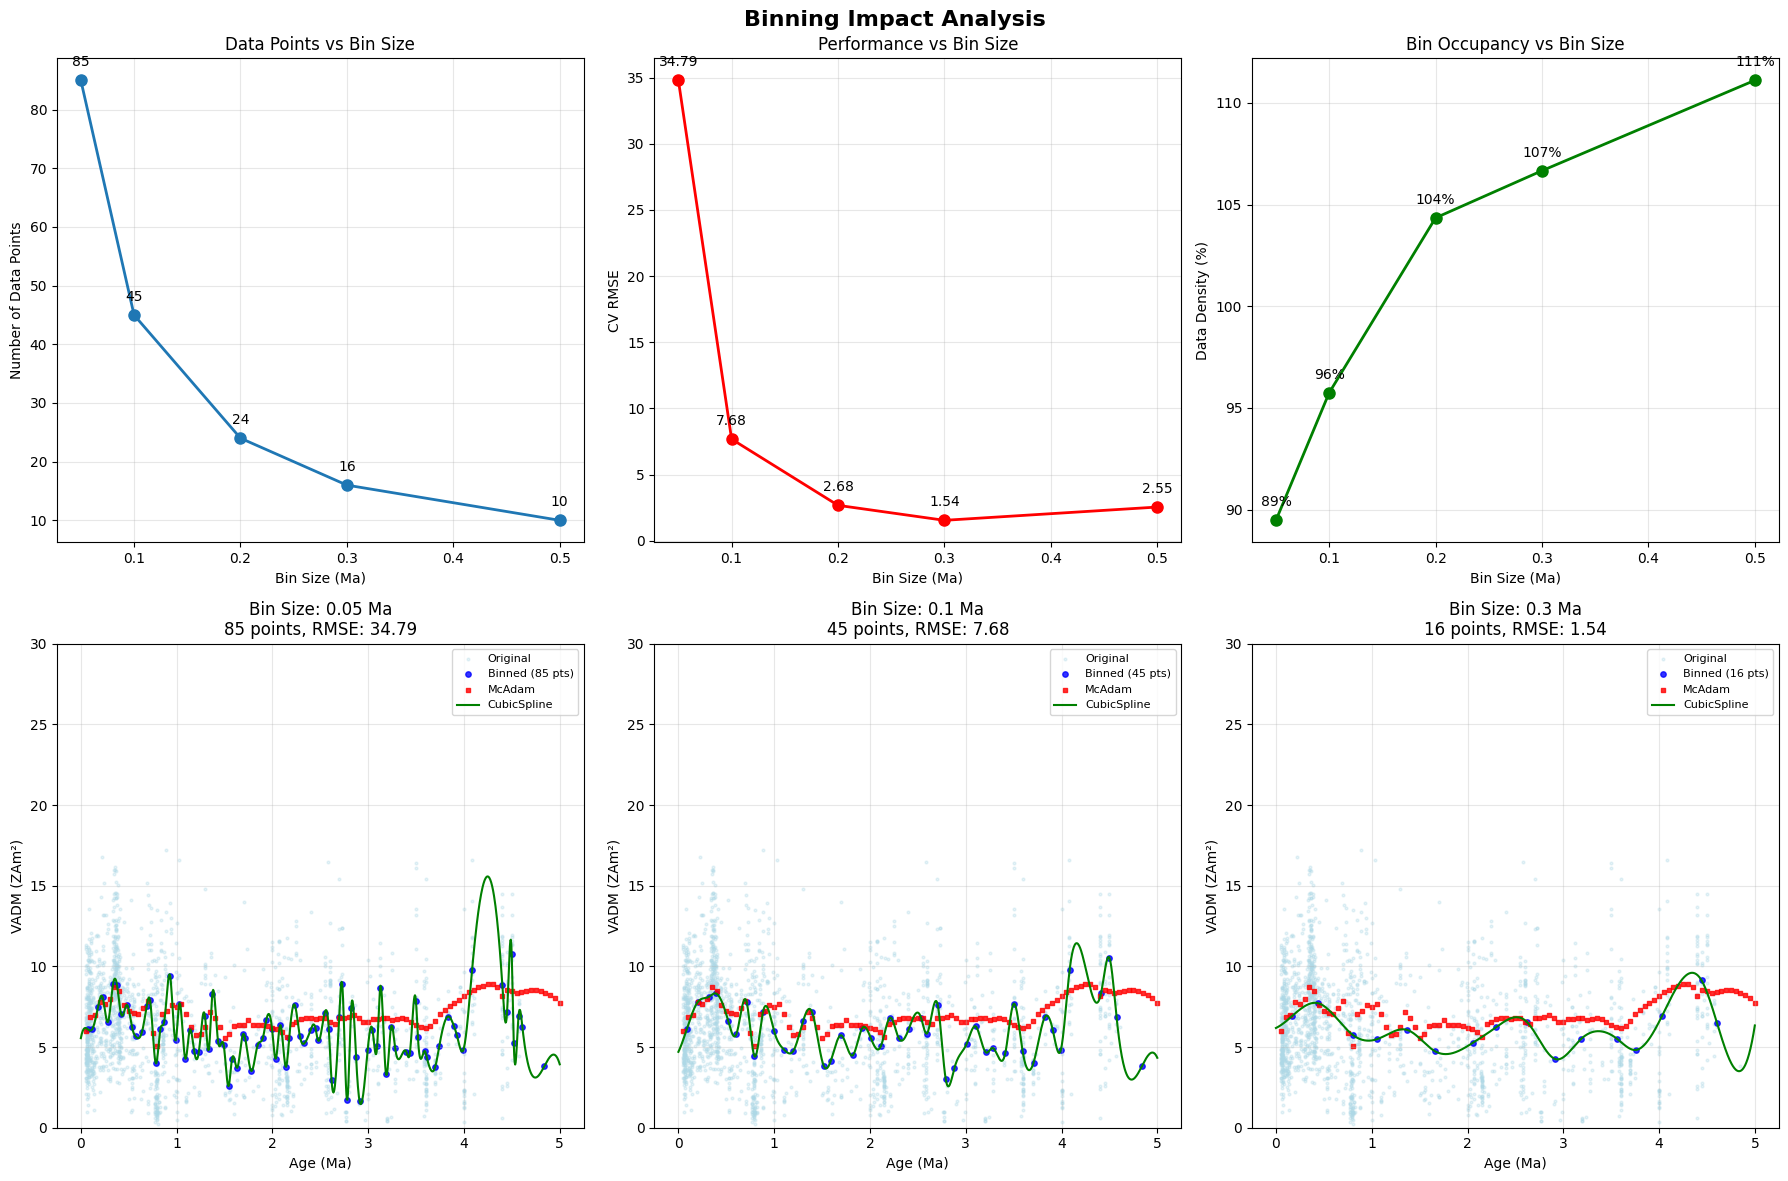


=== BINNING SUMMARY TABLE ===
Bin Size (Ma) Points   Theoretical  Density    CV RMSE    Recommendation 
---------------------------------------------------------------------------
0.05         85       95           89.5     % 34.789     Good balance   
0.1          45       47           95.7     % 7.678      Risky (low n)  
0.2          24       23           104.3    % 2.676      Risky (low n)  
0.3          16       15           106.7    % 1.544      Too few points 
0.5          10       9            111.1    % 2.547      Too few points 

=== ¿POR QUÉ 45 PUNTOS? ===
1. NO es una elección deliberada
2. Es el resultado de: (5.0 - 0.0) Ma / 0.1 Ma ≈ 50 bins teóricos
3. Algunos bins están vacíos → ~45 puntos reales
4. Con ~2000 puntos originales, NO necesitas binning

=== RECOMENDACIONES ===
• Con 2000+ puntos: USA DATOS ORIGINALES (sin binning)
• Binning solo útil si:
  - Datos muy ruidosos
  - Quieres suavizar temporalmente
  - Reducir carga computacional
• Si usas binning:
  - bin_siz

In [ ]:
def analyze_binning_impact(data_vadm, mc_adam=None):
    """Analyze how different bin sizes affect the results"""
    reconstructor = ImprovedSplineReconstruction(data_vadm)

    # Clean data first
    data_clean, _ = reconstructor.detect_outliers(method='iqr', factor=2.0)

    # Different bin sizes to test
    bin_sizes = [0.05, 0.1, 0.2, 0.3, 0.5]  # Different temporal resolutions

    print("=== BINNING IMPACT ANALYSIS ===")
    print(f"Original data: {len(data_clean)} points")
    print(f"Age range: {data_clean['AGE'].min():.3f} to {data_clean['AGE'].max():.3f} Ma")
    print(f"Total time span: {data_clean['AGE'].max() - data_clean['AGE'].min():.3f} Ma")

    results_by_binsize = {}

    for bin_size in bin_sizes:
        print(f"\n--- BIN SIZE: {bin_size} Ma ---")

        # Calculate theoretical and actual number of bins
        theoretical_bins = int((data_clean['AGE'].max() - data_clean['AGE'].min()) / bin_size)

        try:
            # Create binned data
            binned_data = reconstructor.bin_data(bin_size=bin_size, method='mean')
            actual_points = len(binned_data)

            print(f"Theoretical bins: {theoretical_bins}")
            print(f"Actual points: {actual_points}")
            print(f"Empty bins: {theoretical_bins - actual_points}")
            print(f"Data density: {actual_points/theoretical_bins:.1%}")

            # Test CubicSpline performance
            try:
                age_interp, vadm_interp, spline_obj, method_name, data_used = reconstructor.create_robust_spline(
                    binned_data, method='cubic_natural'
                )

                residual_stats = reconstructor.calculate_residuals_with_cv(data_used, spline_obj, method_name)

                if residual_stats:
                    cv_rmse = residual_stats['cv_rmse']
                    print(f"CV RMSE: {cv_rmse:.3f}")
                else:
                    cv_rmse = np.nan
                    print("CV RMSE: ERROR")

                results_by_binsize[bin_size] = {
                    'theoretical_bins': theoretical_bins,
                    'actual_points': actual_points,
                    'empty_bins': theoretical_bins - actual_points,
                    'density': actual_points/theoretical_bins,
                    'cv_rmse': cv_rmse,
                    'binned_data': binned_data
                }

            except Exception as e:
                print(f"Spline error: {str(e)[:50]}...")
                results_by_binsize[bin_size] = {
                    'theoretical_bins': theoretical_bins,
                    'actual_points': actual_points,
                    'empty_bins': theoretical_bins - actual_points,
                    'density': actual_points/theoretical_bins,
                    'cv_rmse': np.nan,
                    'binned_data': binned_data
                }

        except Exception as e:
            print(f"Binning error: {str(e)[:50]}...")

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Binning Impact Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Number of points vs bin size
    ax = axes[0, 0]
    bin_sizes_plot = [bs for bs in bin_sizes if bs in results_by_binsize]
    points_plot = [results_by_binsize[bs]['actual_points'] for bs in bin_sizes_plot]

    ax.plot(bin_sizes_plot, points_plot, 'o-', linewidth=2, markersize=8)
    for i, (bs, pts) in enumerate(zip(bin_sizes_plot, points_plot)):
        ax.annotate(f'{pts}', (bs, pts), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Bin Size (Ma)')
    ax.set_ylabel('Number of Data Points')
    ax.set_title('Data Points vs Bin Size')
    ax.grid(True, alpha=0.3)

    # Plot 2: RMSE vs bin size
    ax = axes[0, 1]
    rmse_plot = [results_by_binsize[bs]['cv_rmse'] for bs in bin_sizes_plot if not np.isnan(results_by_binsize[bs]['cv_rmse'])]
    bin_sizes_valid = [bs for bs in bin_sizes_plot if not np.isnan(results_by_binsize[bs]['cv_rmse'])]

    if rmse_plot:
        ax.plot(bin_sizes_valid, rmse_plot, 'o-', linewidth=2, markersize=8, color='red')
        for i, (bs, rmse) in enumerate(zip(bin_sizes_valid, rmse_plot)):
            ax.annotate(f'{rmse:.2f}', (bs, rmse), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Bin Size (Ma)')
    ax.set_ylabel('CV RMSE')
    ax.set_title('Performance vs Bin Size')
    ax.grid(True, alpha=0.3)

    # Plot 3: Data density
    ax = axes[0, 2]
    density_plot = [results_by_binsize[bs]['density']*100 for bs in bin_sizes_plot]

    ax.plot(bin_sizes_plot, density_plot, 'o-', linewidth=2, markersize=8, color='green')
    for i, (bs, dens) in enumerate(zip(bin_sizes_plot, density_plot)):
        ax.annotate(f'{dens:.0f}%', (bs, dens), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Bin Size (Ma)')
    ax.set_ylabel('Data Density (%)')
    ax.set_title('Bin Occupancy vs Bin Size')
    ax.grid(True, alpha=0.3)

    # Plot 4-6: Example splines for different bin sizes
    example_sizes = [0.05, 0.1, 0.3] if all(bs in results_by_binsize for bs in [0.05, 0.1, 0.3]) else bin_sizes_plot[:3]

    for i, bin_size in enumerate(example_sizes):
        if i < 3 and bin_size in results_by_binsize:
            ax = axes[1, i]

            try:
                binned_data = results_by_binsize[bin_size]['binned_data']
                age_interp, vadm_interp, spline_obj, method_name, data_used = reconstructor.create_robust_spline(
                    binned_data, method='cubic_natural'
                )

                # Plot
                ax.scatter(data_clean['AGE'], data_clean['VADM'], alpha=0.3, s=4, c='lightblue', label='Original')
                ax.scatter(data_used['AGE'], data_used['VADM'], alpha=0.8, s=15, c='blue', label=f'Binned ({len(data_used)} pts)')

                if mc_adam is not None and len(mc_adam) > 0:
                    ax.scatter(mc_adam['AGE'], mc_adam['VADM'], alpha=0.8, s=12, c='red', marker='s', label='McAdam')

                ax.plot(age_interp, vadm_interp, 'g-', linewidth=1.5, label='CubicSpline')

                rmse = results_by_binsize[bin_size]['cv_rmse']
                rmse_text = f'{rmse:.2f}' if not np.isnan(rmse) else 'ERROR'
                ax.set_title(f'Bin Size: {bin_size} Ma\n{len(data_used)} points, RMSE: {rmse_text}')
                ax.set_xlabel('Age (Ma)')
                ax.set_ylabel('VADM (ZAm²)')
                ax.set_ylim(0, 30)
                ax.legend(fontsize=8)
                ax.grid(True, alpha=0.3)

            except Exception as e:
                ax.text(0.5, 0.5, f'Error with\nbin_size={bin_size}', transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f'Bin Size: {bin_size} Ma (ERROR)')

    plt.tight_layout()
    plt.show()

    # Summary table
    print(f"\n=== BINNING SUMMARY TABLE ===")
    print(f"{'Bin Size (Ma)':<12} {'Points':<8} {'Theoretical':<12} {'Density':<10} {'CV RMSE':<10} {'Recommendation':<15}")
    print("-" * 75)

    for bin_size in bin_sizes:
        if bin_size in results_by_binsize:
            result = results_by_binsize[bin_size]
            rmse_str = f"{result['cv_rmse']:.3f}" if not np.isnan(result['cv_rmse']) else "ERROR"

            # Recommendations based on data points
            if result['actual_points'] < 20:
                rec = "Too few points"
            elif result['actual_points'] < 50:
                rec = "Risky (low n)"
            elif result['actual_points'] < 200:
                rec = "Good balance"
            else:
                rec = "Conservative"

            print(f"{bin_size:<12} {result['actual_points']:<8} {result['theoretical_bins']:<12} {result['density']*100:<9.1f}% {rmse_str:<10} {rec:<15}")

    return results_by_binsize

# EJECUTAR ANÁLISIS
print("=== ANÁLISIS DEL IMPACTO DEL BINNING ===")
binning_results = analyze_binning_impact(data_vadm, mc_adam)

print("\n=== ¿POR QUÉ 45 PUNTOS? ===")
print("1. NO es una elección deliberada")
print("2. Es el resultado de: (5.0 - 0.0) Ma / 0.1 Ma ≈ 50 bins teóricos")
print("3. Algunos bins están vacíos → ~45 puntos reales")
print("4. Con ~2000 puntos originales, NO necesitas binning")

print("\n=== RECOMENDACIONES ===")
print("• Con 2000+ puntos: USA DATOS ORIGINALES (sin binning)")
print("• Binning solo útil si:")
print("  - Datos muy ruidosos")
print("  - Quieres suavizar temporalmente")
print("  - Reducir carga computacional")
print("• Si usas binning:")
print("  - bin_size = 0.05 Ma → ~100 puntos (más detalle)")
print("  - bin_size = 0.1 Ma → ~45 puntos (balance)")
print("  - bin_size = 0.2 Ma → ~25 puntos (muy suavizado)")